# Annotated Scatterplot with Categorical Zoom Facets

This data visualization tutorial tackles a common pair of data visualization objectives: *1)* showing how data between categories relate and *2)* showing how data within each category are structured.

To this end, we'll build a visualization for the demographics of the most wealthy members of different industries.
Data for this exercise comes from [Joy Shill via Kaggle](https://www.kaggle.com/datasets/joyshil0599/exploring-wealth-forbes-richest-people-dataset).

In our visualization, we will look at how the demographics of the upper echelons of different industries are structured and how that structure compares between industries.
Scatterploting age versus wealth faceted per industry will provide a good view of individual industries' top-tier compositions.
To aid comparison of demographics between industries, we'll provide a summary plot and structure our industry-specific facets zoomed outsets of the summary plot.
We'll arrange the main plot and the zoom outsets together as an axes grid.

To take on this latter task --- composing a primary axes with a faceted grid of zoomed views  --- we'll make use of  `outset` library, which provides convenient tools to this end.

## Visualization Result

Here's a sneak peek at the visualization we'll be building!

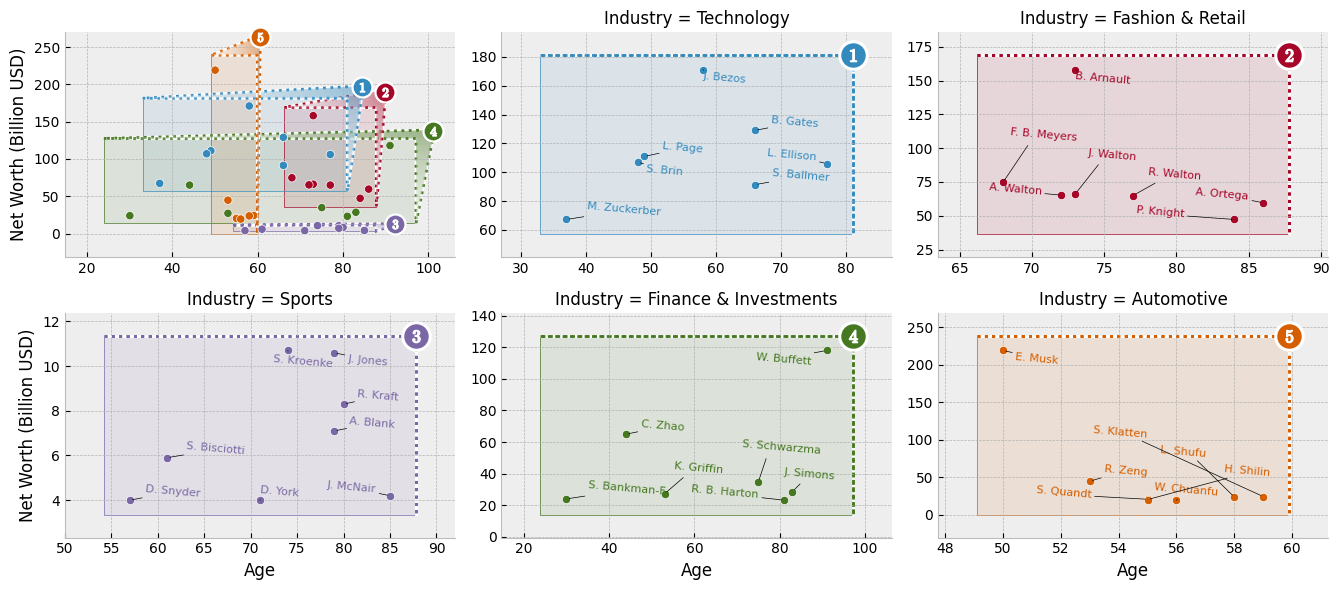

In [11]:
try:
    display(grid.figure)  # shows completed figure if notebook already ran
except NameError:
    pass

Let's start coding!

## Setup

Begin by importing necessary packages.

Notably:
- `adjustText` for nudging scatterplot text labels to prevent overlap
- `matplotlib` as the graphics engine
- `outset` for managing multi-zoom grid and zoom indicators
- `pandas` for data management

In [2]:
import typing

from adjustText import adjust_text
import outset as otst
from outset import patched as otst_patched
from matplotlib import pyplot as plt
import pandas as pd

plt.style.use("bmh")  # aesthetics: switch matplotlib style sheet

To install dependencies for this exercise,

```bash
python3 -m pip install \
    adjustText `# ==0.8` \
    matplotlib `# ==3.8.2`\
    numpy `# ==1.26.2` \
    outset `# ==0.1.4` \
    opytional `# ==0.1.0` \
    pandas `# ==2.1.3`
```

## Data Preparation

Next, let's fetch our data and do a little work on it.
We'll need to clean up the "Net Worth" column, which is polluted with dollar signs and textual "billion" qualifiers.
We'll also shorten the names of the people in our dataset so they're easier to plot and rank everyone within their own industry in order to isolate the upper echelons of each industry.

In [3]:
df = pd.read_csv("https://osf.io/bvrjm/download")  # download data
df["Net Worth (Billion USD)"] = (
    # strip out pesky non-numeric characters then convert to float
    df["Net Worth"]
    .str.replace(r"[^.0-9]+", "", regex=True)
    .astype(float)
)
df["Who"] = (  # shorten names so they're easier to plot...
    df["Name"]
    .str.replace(r"\s*&.*", "", regex=True)  # ... remove "& family"
    .replace(r"(\b[A-Za-z])\w+\s+", r"\1. ", regex=True)  # abbrev F. Lastname
    .str.slice(0, 12)  # chop long names to 12 characters
)

# rank everyone by wealth within their industry
df["Industry Rank"] = df.groupby("Industry")["Net Worth (Billion USD)"].rank(
    method="dense", ascending=False
)

For tractability, we will visualize only a subset of industry categories.
Here's a few with interesting contrast in demographic structure.

In [4]:
focal_industries = [
    "Technology",
    "Fashion & Retail",
    "Sports",
    "Finance & Investments",
    "Automotive",
]

# Setup Axes Grid

Now it's time to get started plotting.
We can use an the outset library's `OutsetGrid` class to manage content and layout of our faceted axes grid.
This tool operates analogously to seaborn's [`FacetGrid`](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html), if you're familiar with that.

We pass `OutsetGrid` a data frame containing our data, the names of the columns we want to use for the x and y axes, and the names of the columns we want to use to split our data into facets.
Passing the `hue` kwarg will supplement faceting with color-coding by industry.
Other kwargs provide styling and layout information, including how we want plots to be shaped and how many columns we want to have.

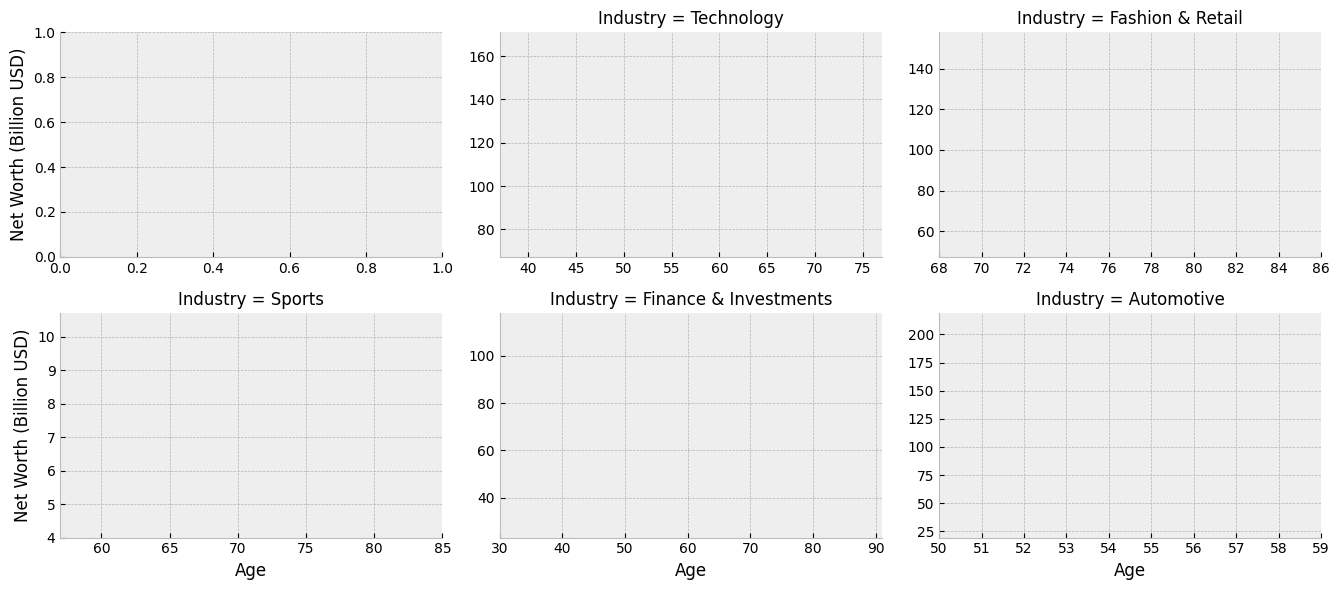

In [5]:
grid = otst.OutsetGrid(  # setup axes grid manager
    df[(df["Industry Rank"] < 8)].dropna(),  # only top 8 in each industry
    x="Age",
    y="Net Worth (Billion USD)",
    col="Industry",
    hue="Industry",
    col_order=focal_industries,  # subset to our focal industries
    hue_order=focal_industries,
    aspect=1.5,  # widen subplots
    col_wrap=3,
)

pass  # sponge up last return value, if any

## Set Up Plot Content

Next, we'll scatterplot our billionaire's ages and wealths.
We need to add each billionaire to the main plot and to their industry's outset plot.

We'll use a patched version of seaborn's `scatterplot` function bundled with `outset` due to an [open seaborn issue](https://github.com/mwaskom/seaborn/issues/3601).
We will use `OutsetGrid.map_dataframe` to plot appropriate data and colors on each axes.
The `map_dataframe` method works analogously it its equivalent on seaborn's `FacetGrid.
The first argument provides a plotter function, which is called with subsequent arguments forwarded on each axes.

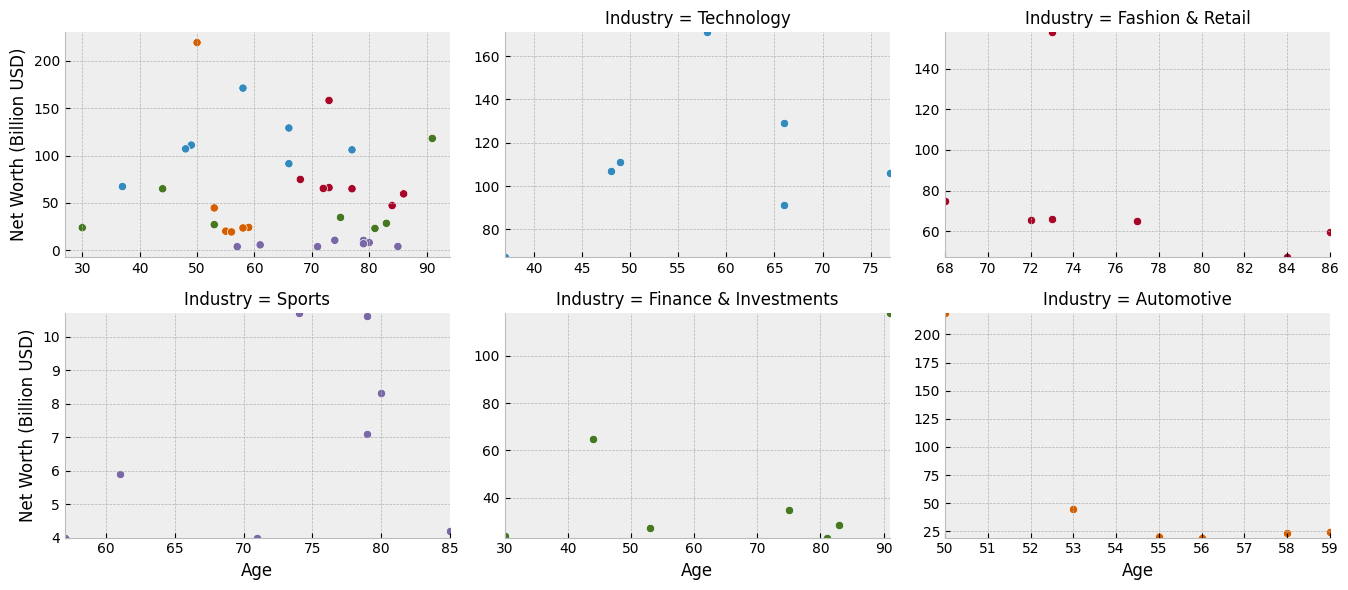

In [6]:
grid.map_dataframe(  # map scatterplot over all axes
    otst_patched.scatterplot,
    x="Age",
    y="Net Worth (Billion USD)",
    legend=False,
)

display(grid.figure)  # show current progress

pass  # sponge up last return value, if any

# Annotate Outset Plots with Names

Our next task is to identify plotted billionaires by name by labeling scatter points on outset plots.
To get a good result, some care must be taken to avoid overlapping text labels with each other or with the plotted points.
The awesome [adjustText](https://github.com/Phlya/adjustText) library can help us here by automatically nudging text labels to avoid overlap.

Let's put together a data-oriented helper function to do all this that we can map over the outset axes in our grid.

In [7]:
def annotateplot(
    data: pd.DataFrame,
    *,
    x: str,
    y: str,
    text: str,
    ax: typing.Optional[plt.Axes] = None,
    adjusttext_kws: typing.Optional[typing.Mapping] = None,
    **kwargs: dict,
) -> plt.Axes:
    """Annotate a plot coordinates with text labels, then apply adjustText to
    rearrange the labels to avoid overlaps.

    Parameters
    ----------
    data : pd.DataFrame
        The DataFrame containing the data to plot.
    x : str
        The name of the column in `data` to use for the x-axis values.
    y : str
        The name of the column in `data` to use for the y-axis values.
    text : Optional[str], default None
        The name of the column in `data` to use for text values.
    ax : Optional[plt.Axes], default None
        The matplotlib Axes object to draw the plot onto, if provided.
    adjusttext_kws : Mapping, default {}
        Additional keyword arguments forward to adjustText.
    **kwargs : dict
        Additional keyword arguments forward to seaborn's regplot.

    Returns
    -------
    plt.Axes
        The matplotlib Axes containing the plot.
    """
    if adjusttext_kws is None:
        adjusttext_kws = {}

    if ax is None:
        ax = plt.gca()

    kwargs.pop("legend", None)  # ignore these kwargs
    kwargs.pop("label", None)

    texts = [  # add text for each row in data
        ax.text(row[x], row[y], row[text], **kwargs) for _idx, row in data.iterrows()
    ]
    adjust_text(texts, ax=ax, **adjusttext_kws)

    return ax

A call to `OutsetGrid.map_dataframe_outset` applies this function to just the outset axes in our grid.

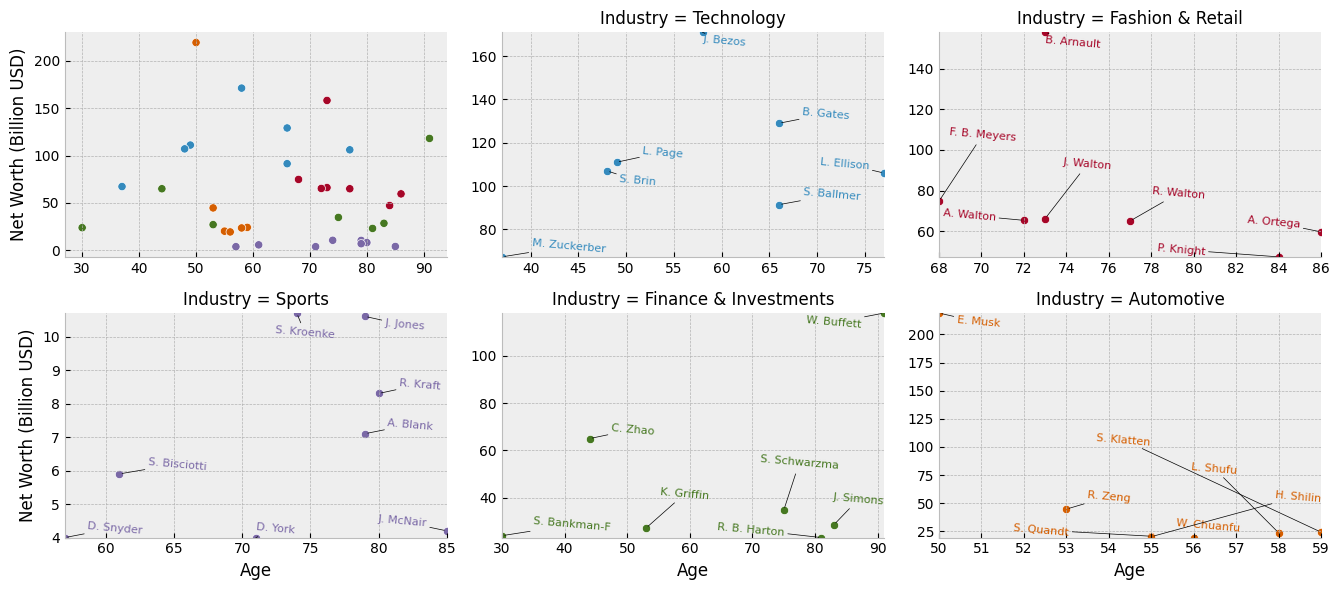

In [8]:
grid.map_dataframe_outset(  # map name annotations over all outset axes
    otst_patched.annotateplot,
    x="Age",
    y="Net Worth (Billion USD)",
    text="Who",
    fontsize=8,  # make text slightly smaller so it's easier to lay out
    rotation=-5,
    adjusttext_kws=dict(  # tweak fiddly params for text layout solver
        avoid_self=True,
        autoalign=True,
        expand_points=(1.8, 1.3),
        arrowprops=dict(arrowstyle="-", color="k", lw=0.5),
        expand_text=(1.8, 2),
        force_points=(1.2, 1),
        ha="center",
        va="top",
    ),
)

display(grid.figure)  # show current progress

pass  # sponge up last return value, if any

# Add Zoom Indicators

Now it's time to add zoom indicator boxes, a.k.a. `outset` "marquees," to show how the scales of our auxiliary plots relate to the scale of the main plot.
Note that we pass the `equalize_aspect` kwarg so that aspect ratios can vary between the main plot and outset plots.
That way, zoom areas will expand to take full advantage of available space.

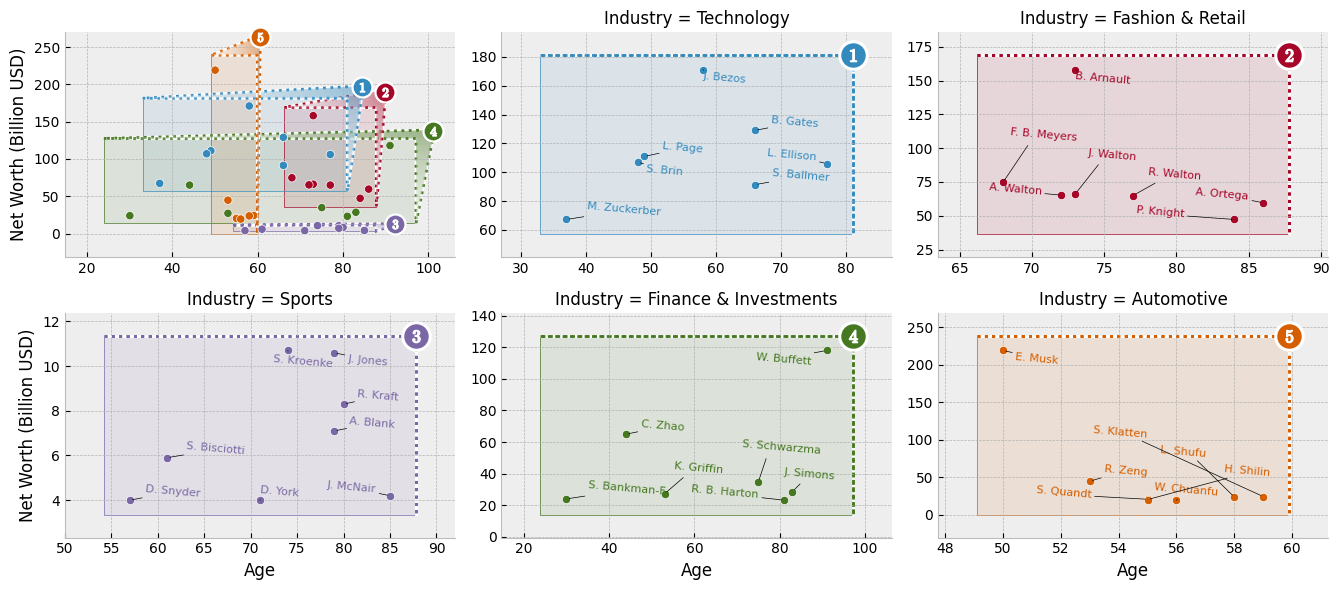

In [9]:
# draw "marquee' zoom indicators showing correspondences between main plot
# and outset plots
grid.marqueeplot(equalize_aspect=False)  # allow axes aspect ratios to vary

display(grid.figure)  # show current progress

pass  # sponge up last return value, if any

# Et Voilà!

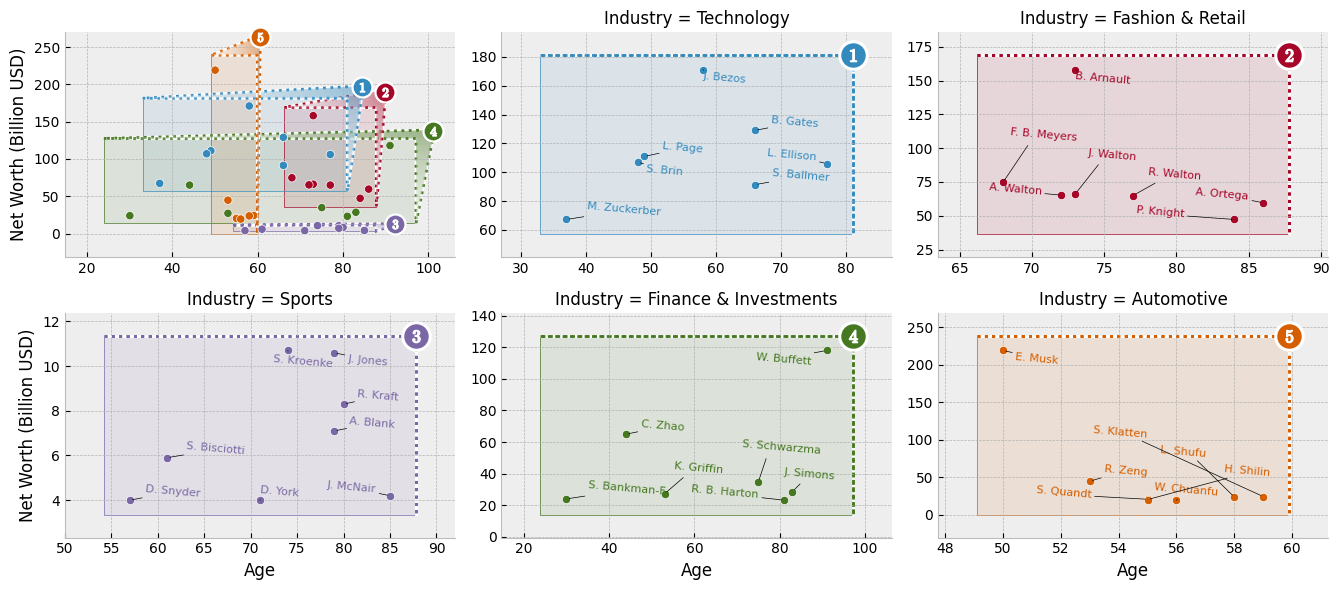

In [10]:
display(grid.figure)  # show completed figure!

pass  # sponge up last return value, if any

## Further Information

Refer to the `outset` [*quickstart guide*](https://mmore500.com/outset/quickstart.html) and [*gallery*](https://mmore500.com/outset/gallery.html) for more information about that library.
In addition to data-oriented zoom area selection shown above, the library also provides an explicit API to manually specify zoom areas as well as many styling and layout options.
There are tools to reposition "outset" auxiliary axes as insets over the main axes, too.

## Authorship

This tutorial is contributed by me, [Matthew Andres Moreno](https://mmore500.com/).
I currently serve as a postdoctoral scholar at the University of Michigan, where my work is supported by the Eric and Wendy Schmidt AI in Science Postdoctoral Fellowship, a Schmidt Futures program.
My appointment is split between the university's Ecology and Evolutionary Biology Department, the Center for the Study of Complexity, and the Michigan Institute for Data Science.

Find me on Twitter as [@MorenoMatthewA](https://twitter.com/morenomatthewa) and on GitHub as [@mmore500](https://github.com/mmore500/).

*disclosure:* I am the author of the `outset` library.

## Citations

> Ilya Flyamer, Zhuyi Xue, Colin, Andy Li, JasonMendoza2008, Josh L. Espinoza, Nader Morshed, Oscar Gustafsson, Victor Vazquez, Ryan Neff, mski_iksm, Nikita Vaulin, scaine1, & Oliver Lee. (2023). Phlya/adjustText: 0.8.1 (0.8.1). Zenodo. https://doi.org/10.5281/zenodo.10016869

> J. D. Hunter, "Matplotlib: A 2D Graphics Environment", Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, 2007. https://doi.org/10.1109/MCSE.2007.55

> Matthew Andres Moreno. (2023). mmore500/outset. Zenodo. https://doi.org/10.5281/zenodo.10426106

> Data structures for statistical computing in python, McKinney, Proceedings of the 9th Python in Science Conference, Volume 445, 2010. https://doi.org/ 10.25080/Majora-92bf1922-00a

> Joy Shil. (2023). Exploring Wealth: Forbes Richest People Dataset [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/5272751

> Waskom, M. L., (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021, https://doi.org/10.21105/joss.03021.